# **Task 1**

This is just a simplified presentation of the packaging. The detailed experimental results can be found in the supporting materials under Task 1, in Final_Task1_PredictingTheUnpredictable-Barry.ipynb.

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

!pip install -r "/content/drive/My Drive/ACDS-Barry/requirements.txt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project",
                filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project",
                filename="events.csv", repo_type="dataset", local_dir="data")

'data/events.csv'

In [ ]:
import pandas as pd
import numpy as np
import os
sys.path.append('/content/drive/My Drive/ACDS-Barry/barry/')

from task_1 import *
from task_2 import *
from task_3 import *
from common_functions import *

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Prepare the data

In [ ]:
# Load event metadata
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
event_ids = df["id"].unique()

# Set random seed for reproducibility
np.random.seed(42)
np.random.shuffle(event_ids)  # Shuffle event IDs to randomize data distribution

subset_size = int(0.2 * len(event_ids))
event_ids = np.random.choice(event_ids, size=subset_size, replace=False)

# Split dataset into training (70%), validation (20%), and testing (10%)
train_split = int(0.7 * len(event_ids))
val_split = int(0.2 * len(event_ids))

train_ids = event_ids[:train_split]
val_ids = event_ids[train_split:train_split + val_split]
test_ids = event_ids[train_split + val_split:]

print(f"Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")

Train: 112, Val: 32, Test: 16


## Task 1A

### preprocessing

In [ ]:
# Process and save datasets in compressed format
task_1.task1_preprocess_batch("data/train.h5", train_ids, "train")
task_1.task1_preprocess_batch("data/train.h5", val_ids, "val")
task_1.task1_preprocess_batch("data/train.h5", test_ids, "test")

### Train the model

In [ ]:
train_datasetA = task_1.task1_get_tf_dataset("1A", "data/train")
val_datasetA = task_1.task1_get_tf_dataset("1A", "data/val")
test_datasetA = task_1.task1_get_tf_dataset("1A", "data/test")

In [ ]:
# Train the model
# For task 1A
input_shape = (192, 192, 12, 1)
modela = task_1.task1_build_model(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
modela.compile(optimizer='adam',
              loss="mae",
              metrics=[task_1.total_loss, task_1.mae, task_1.rmse, task_1.kl_divergence,
                       task_1.reconstruction_loss])

In [ ]:
# Train and monitor Task 1A
early_stopping = task_1.EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
reduce_lr = task_1.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6)


def task1_count_files(data_dir, batch_size=40):
    num_files = len(task_1.glob.glob(f"{data_dir}/*.npz"))
    return num_files * batch_size * 7

train_steps_per_epoch = task1_count_files("data/train", batch_size=40)
val_steps_per_epoch = task1_count_files("data/val", batch_size=40)

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

Train steps per epoch: 840
Validation steps per epoch: 280


In [ ]:
train_datasetA = train_datasetA.repeat()
# Make the training data repeat automatically
val_datasetA = val_datasetA.repeat()

history = modela.fit(train_datasetA,
                    epochs=2,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_datasetA,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 583s 585ms/step - kl_divergence: 0.0000e+00 - loss: 0.1161 - mae: 0.1161 - reconstruction_loss: 0.0495 - rmse: 0.1951 - total_loss: 0.0495 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0851 - val_mae: 0.0851 - val_reconstruction_loss: 0.0249 - val_rmse: 0.1500 - val_total_loss: 0.0249 - learning_rate: 0.0010
Epoch 2/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 488s 582ms/step - kl_divergence: 0.0000e+00 - loss: 0.0647 - mae: 0.0647 - reconstruction_loss: 0.0174 - rmse: 0.1235 - total_loss: 0.0174 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0699 - val_mae: 0.0699 - val_reconstruction_loss: 0.0181 - val_rmse: 0.1286 - val_total_loss: 0.0181 - learning_rate: 0.0010


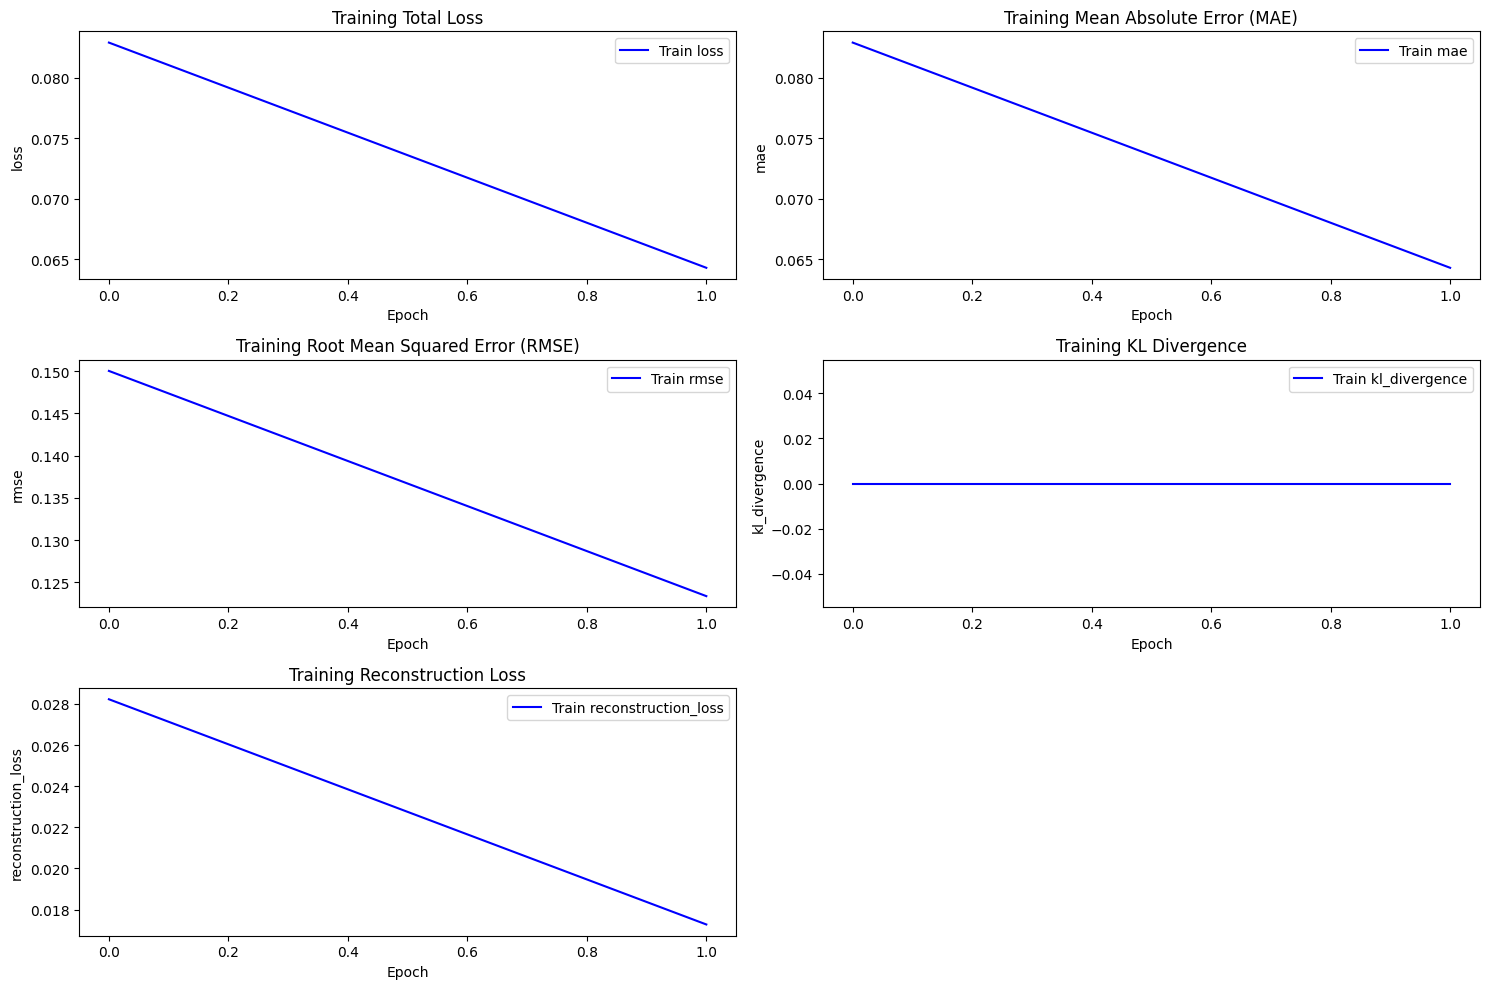

In [ ]:
task_1.task1_plot_training_history(history)

In [ ]:
# Save the model to Google Drive
modela.save("/content/drive/MyDrive/ACDS-Barry/supporting_materials/Task1/task1a_model.keras")
print("Model saved")

Model saved


#### Evaluation the model

In [ ]:
# Load saved model
saved = task_1.load_model("/content/drive/MyDrive/ACDS-Barry/supporting_materials/Task1/task1a_model.keras")
task_1.task1_evaluate_test_set(saved, test_datasetA)

Test RMSE: 0.10236
Test MAE: 0.04828
Test KL Divergence: 0.08158
Test Reconstruction Loss: 0.01187
Test Total Loss: 0.09345


#### Show the prediction frames

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


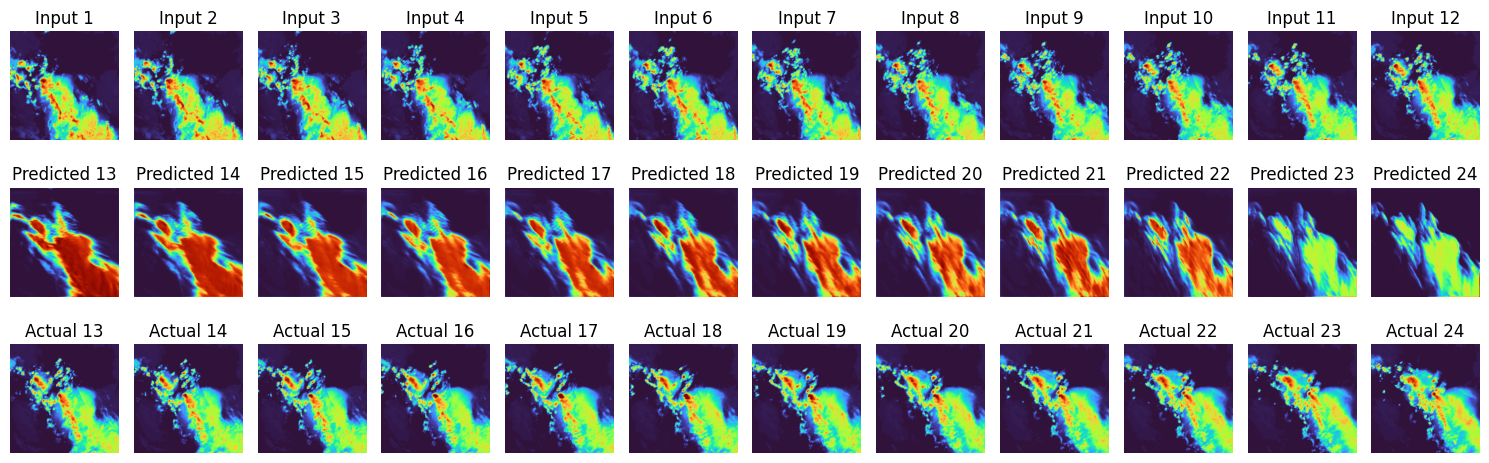

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


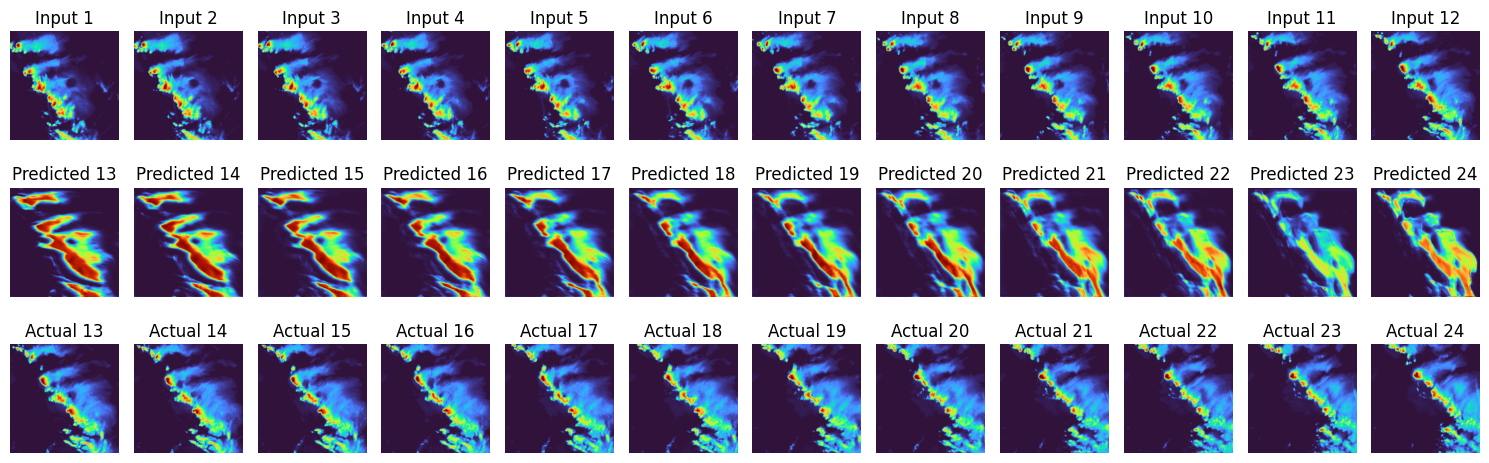

In [ ]:
# Prediction

# Gets the iterator for the test set
test_iterator = iter(test_datasetA)

# First
X_sample, Y_sample = next(test_iterator)
predicted = task_1.task1_predict_frames(saved, X_sample.numpy())
task_1.task1_plot_predicted_frames(X_sample.numpy(), predicted, Y_sample.numpy())

# Second
X_sample1, Y_sample1 = next(test_iterator)
predicted1 = task_1.task1_predict_frames(saved, X_sample1.numpy())
task_1.task1_plot_predicted_frames(X_sample1.numpy(), predicted1, Y_sample1.numpy())

## Task1_B

### Train the model

In [ ]:
train_datasetB = task_1.task1_get_tf_dataset("1B", "data/train")
val_datasetB = task_1.task1_get_tf_dataset("1B", "data/val")
test_datasetB = task_1.task1_get_tf_dataset("1B", "data/test")

In [ ]:
# Train the model
# For compare, we use the same model
# For task 1B
input_shape_b = (192, 192, 12, 4)
model_b = task_1.task1_build_model(input_shape_b)

In [ ]:
model_b.compile(optimizer='adam',
                loss="mae",
                metrics=[task_1.t1_total_loss, task_1.t1_mae, task_1.t1_rmse, task_1.t1_kl_divergence,
                       task_1.t1_reconstruction_loss])

In [ ]:
# Train and monitor Task 1B
early_stopping = task_1.EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)
reduce_lr = task_1.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6)

def task1_count_files(data_dir, batch_size=40):
    num_files = len(task_1.glob.glob(f"{data_dir}/*.npz"))
    return num_files * batch_size * 7

train_steps_per_epoch = task1_count_files("data/train", batch_size=40)
val_steps_per_epoch = task1_count_files("data/val", batch_size=40)

print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

Train steps per epoch: 840
Validation steps per epoch: 280


In [ ]:
train_datasetB = train_datasetB.repeat()
# Make the training data repeat automatically
val_datasetB = val_datasetB.repeat()

history_b = model_b.fit(train_datasetB,
                        epochs=2,
                        steps_per_epoch=train_steps_per_epoch,
                        validation_data=val_datasetB,
                        validation_steps=val_steps_per_epoch,
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 595s 600ms/step - kl_divergence: 0.0000e+00 - loss: 0.1158 - mae: 0.1158 - reconstruction_loss: 0.0503 - rmse: 0.1985 - total_loss: 0.0503 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0916 - val_mae: 0.0916 - val_reconstruction_loss: 0.0296 - val_rmse: 0.1642 - val_total_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/2
840/840 ━━━━━━━━━━━━━━━━━━━━ 501s 596ms/step - kl_divergence: 0.0000e+00 - loss: 0.0696 - mae: 0.0696 - reconstruction_loss: 0.0195 - rmse: 0.1310 - total_loss: 0.0195 - val_kl_divergence: 0.0000e+00 - val_loss: 0.0949 - val_mae: 0.0949 - val_reconstruction_loss: 0.0306 - val_rmse: 0.1669 - val_total_loss: 0.0306 - learning_rate: 0.0010


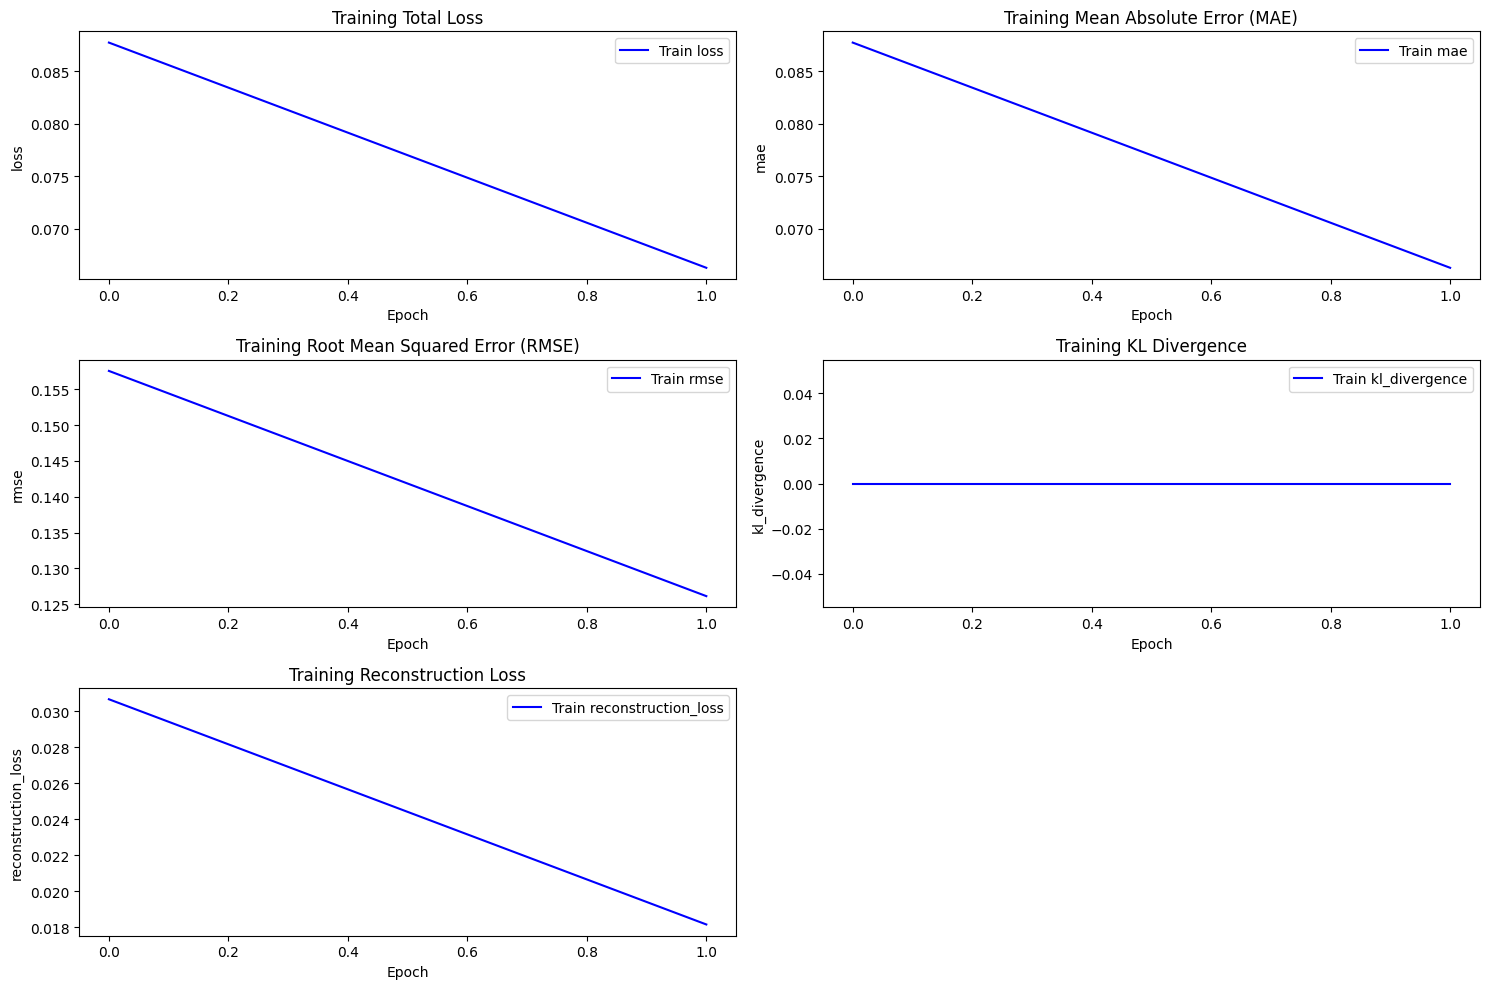

In [ ]:
# Plot Loss change curves for training and validation
task_1.task1_plot_training_history(history_b)

In [ ]:
# Save the model to Google Drive
model_b.save("/content/drive/MyDrive/task1b_model.keras")
print("Model for B saved")

Model for B saved


### evaluation the model

In [ ]:
# Load saved model
saved_b = task_1.load_model("/content/drive/MyDrive/task1b_model.keras")

# Evaluation of the 1B
task_1.task1_evaluate_test_set(saved_b, test_datasetB)

Test RMSE: 0.12350
Test MAE: 0.06043
Test KL Divergence: 0.15326
Test Reconstruction Loss: 0.01763
Test Total Loss: 0.17089


### Show the prediction frames

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


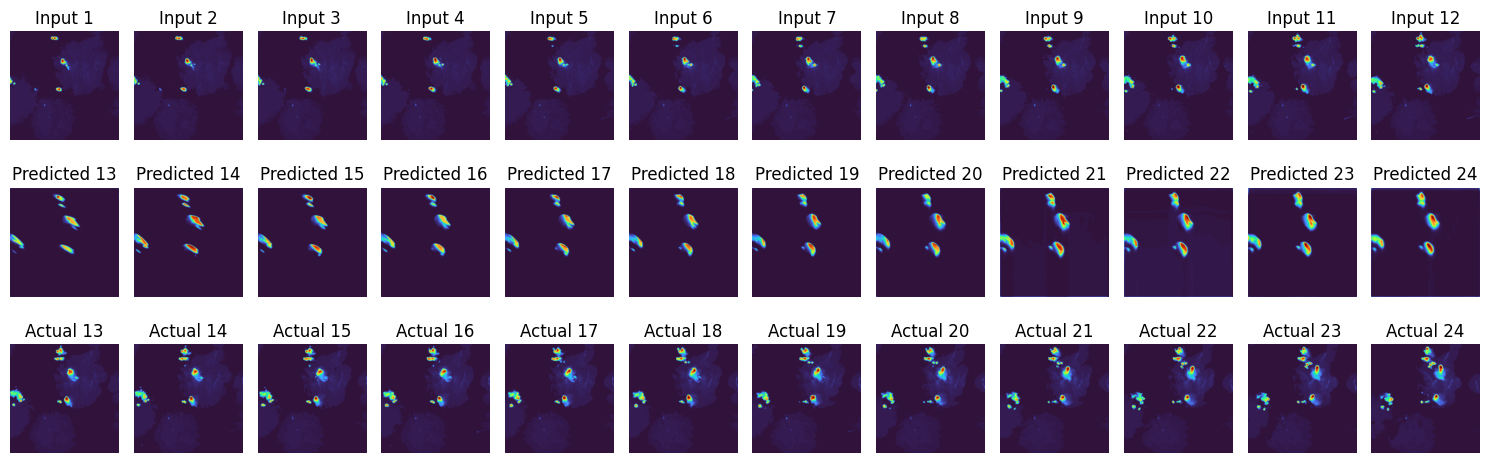

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


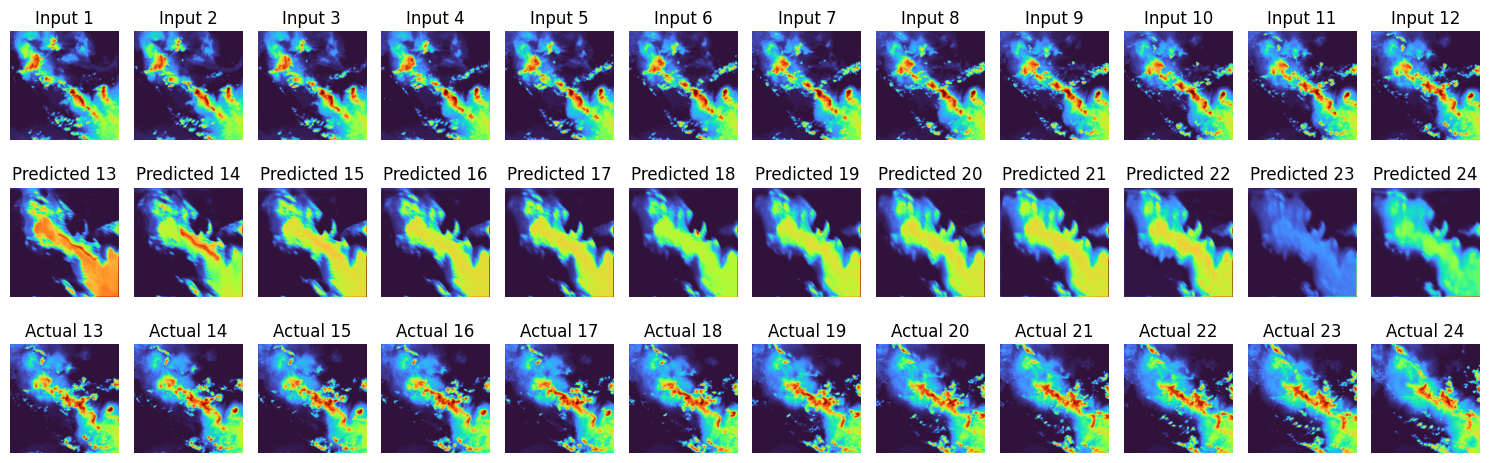

In [ ]:
# Gets the iterator for the test set
test_iterator2 = iter(test_datasetB)

# First
X_sample2, Y_sample2 = next(test_iterator2)
predicted2 = task_1.task1_predict_frames(saved_b, X_sample2.numpy())
task_1.task1_plot_predicted_frames_b(X_sample2.numpy(), predicted2, Y_sample2.numpy())

# Second
X_sample3, Y_sample3 = next(test_iterator2)
predicted3 = task_1.task1_predict_frames(saved_b, X_sample3.numpy())
task_1.task1_plot_predicted_frames_b(X_sample3.numpy(), predicted3, Y_sample3.numpy())

## Bonus Task

### 1. Scaling Laws

**Compute Scaling**

Increasing GPU resources improved training speed but showed diminishing returns beyond a certain point.

**Dataset Size Scaling**

Performance improved significantly with more data initially but plateaued with larger datasets, suggesting a data efficiency limit.

**Model Size Scaling**

Larger models captured more complex patterns but required more data to generalize well and were prone to overfitting.


### 2. Explainability

We added an extra convolutional layer and increased the filter size from 32 to 64, enhancing feature extraction and improving the model’s ability to capture spatial dependencies.

To prevent RAM and GPU overload, we downscaled images to 192 during training and restored them to 384 in the final stage, balancing computational efficiency with model performance.

**Saliency Maps**

Visualized key spatial-temporal features affecting predictions. Grad-CAM and occlusion analysis to visualize which spatial-temporal features influence predictions, providing insights into how the model processes risk patterns.